Целью данного проекта является прогнозирование уровня популярности видеоигр на основе их метаданных.

Для каждой игры из датасета (включающего такие признаки, как название, дата релиза, цена, возрастной рейтинг, жанры, теги, категории, поддерживаемые платформы, разработчики, издатели и другие характеристики) требуется определить её класс популярности, закодированный как:

* 0 — низкая популярность,
* 1 — средняя популярность,
* 2 — высокая популярность.

Задача представляет собой многоклассовую классификацию

Модель может быть использована для:
* оценки потенциального успеха игры до её релиза,
*рекомендаций разработчикам по выбору жанров, тегов и платформ,


In [47]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb


from typing import Final
from enum import IntEnum
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import confusion_matrix
from scipy.stats import randint, uniform
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
DATASET_REF: Final[str] = 'fronkongames/steam-games-dataset'
CSV_FILENAME: Final[str] = 'games.json'
JSON_PATH: Final[str] = f'{kagglehub.dataset_download(DATASET_REF)}/{CSV_FILENAME}'

СOLUMN_NAME_DICT: Final = {
    'name': 'Name',
    'release_date': 'Release date',
    'required_age': 'Required age',
    'price': 'Price',
    'dlc_count': 'DLC count',
    'detailed_description': 'Detailed description',
    'about_the_game': 'About the game',
    'short_description': 'Short description',
    'reviews': 'Reviews',
    'header_image': 'Header image',
    'website': 'Website',
    'support_url': 'Support url',
    'support_email': 'Support email',
    'windows': 'Windows',
    'mac': 'Mac',
    'linux': 'Linux',
    'metacritic_score': 'Metacritic score',
    'metacritic_url': 'Metacritic url',
    'achievements': 'Achievements',
    'recommendations': 'Recommendations',
    'notes': 'Notes',
    'supported_languages': 'Supported languages',
    'full_audio_languages': 'Full audio languages',
    'packages': 'Packages',
    'developers': 'Developers',
    'publishers': 'Publishers',
    'categories': 'Categories',
    'genres': 'Genres',
    'screenshots': 'Screenshots',
    'movies': 'Movies',
    'user_score': 'User score',
    'score_rank': 'Score rank',
    'positive': 'Positive',
    'negative': 'Negative',
    'estimated_owners': 'Estimated owners',
    'average_playtime_forever': 'Average playtime forever',
    'average_playtime_2weeks': 'Average playtime two weeks',
    'median_playtime_forever': 'Median playtime forever',
    'median_playtime_2weeks': 'Median playtime two weeks',
    'peak_ccu': 'Peak CCU',
    'tags': 'Tags',
}

FEATURE_COLUMNS: Final = [
    'Name',
    'Release date',
    'Required age',
    'Price',
    'Detailed description',
    'About the game',
    'Short description',
    'Website',
    'Support url',
    'Support email',
    'Windows',
    'Mac',
    'Linux',
    'Notes',
    'Supported languages',
    'Full audio languages',
    'Developers',
    'Publishers',
    'Categories',
    'Genres',
    'Tags',
]

TARGET_SOURCE_COLUMN: Final[str] = "Estimated owners"
TARGET: Final[str] = 'Popularity class'

Using Colab cache for faster access to the 'steam-games-dataset' dataset.


In [ ]:
class PopularityClass(IntEnum):
    UNPOPULAR = 0
    MODERATE = 1
    POPULAR = 2

def map_to_popularity(owner_range: str) -> int:
    if owner_range == '0 - 0':
        return PopularityClass.UNPOPULAR
    elif owner_range == '0 - 20000':
        return PopularityClass.MODERATE
    else:
        return PopularityClass.POPULAR

In [ ]:
# Небольшой костыль, т.к. исходынй файл csv кривой

def convert_dict_to_string(dict_object):
    if len(dict_object) == 0:
        return np.nan
    key_list = list(dict_object.keys())
    keys_string = ','.join(key_list)
    return keys_string

def read_convert_json_dataset():
    _df = pd.read_json(JSON_PATH)
    _df = _df.T
    _df['AppID'] = _df.index
    _df.rename(columns=СOLUMN_NAME_DICT, inplace=True)

    for col in _df.columns.values:
        if isinstance(_df.loc[546560][col], dict):
            _df[col] = _df[col].apply(lambda entries: convert_dict_to_string(entries))
        if isinstance(_df.loc[546560][col], list):
            if isinstance(_df.loc[546560][col][0], str):
                _df[col] = _df[col].apply(lambda entries: ','.join(entries))
    _df = _df.reset_index().set_index('AppID')
    return _df

df_full = read_convert_json_dataset()

In [ ]:
df = (
    df_full[FEATURE_COLUMNS + [TARGET_SOURCE_COLUMN]]
    .copy()
    .assign(**{TARGET: lambda x: x[TARGET_SOURCE_COLUMN].map(map_to_popularity)})
    .drop(columns=TARGET_SOURCE_COLUMN)
)

df['Release date'] = pd.to_datetime(df['Release date'], errors='coerce')
df['Release month'] = df['Release date'].dt.month
df['Release month_cos'] = np.cos(2 * np.pi * df['Release date'].dt.month / 12)
df['Release month_sin'] = np.sin(2 * np.pi * df['Release date'].dt.month / 12)

df['Required age'] = (
    pd.to_numeric(df['Required age'], errors='coerce')
    .fillna(0)
    .astype('Int64')
)

df['Price'] = pd.to_numeric(df['Price'], errors='coerce').astype('Float64')

os_columns = ['Windows', 'Mac', 'Linux']
df[os_columns] = df[os_columns].astype('boolean')

text_columns = [
    'Website', 'Support url', 'Support email', 'Notes',
    'Supported languages', 'Full audio languages',
    'Developers', 'Publishers', 'Categories', 'Genres', 'Tags'
]

df[text_columns] = (
    df[text_columns]
    .replace('', np.nan)
    .astype('object')
)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 111452 entries, 20200 to 3183790
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Name                  111452 non-null  object        
 1   Release date          111321 non-null  datetime64[ns]
 2   Required age          111452 non-null  Int64         
 3   Price                 111452 non-null  Float64       
 4   Detailed description  111452 non-null  object        
 5   About the game        111452 non-null  object        
 6   Short description     111452 non-null  object        
 7   Website               46458 non-null   object        
 8   Support url           50815 non-null   object        
 9   Support email         92444 non-null   object        
 10  Windows               111452 non-null  boolean       
 11  Mac                   111452 non-null  boolean       
 12  Linux                 111452 non-null  boolean       
 13 

In [ ]:
numeric_cols = ['Release month', 'Required age', 'Price', 'Popularity class']

In [ ]:
display(df[numeric_cols].describe(include='all'))

,Release month,Required age,Price,Popularity class
count,111321.000000,111452.0,111452.0,111452.000000
mean,6.560838,0.254208,7.061568,0.973657
std,3.479298,2.035653,12.563246,0.607773
min,1.000000,0.0,0.0,0.000000
25%,3.000000,0.0,0.99,1.000000
50%,7.000000,0.0,3.99,1.000000
75%,10.000000,0.0,9.99,1.000000
max,12.000000,21.0,999.98,2.000000


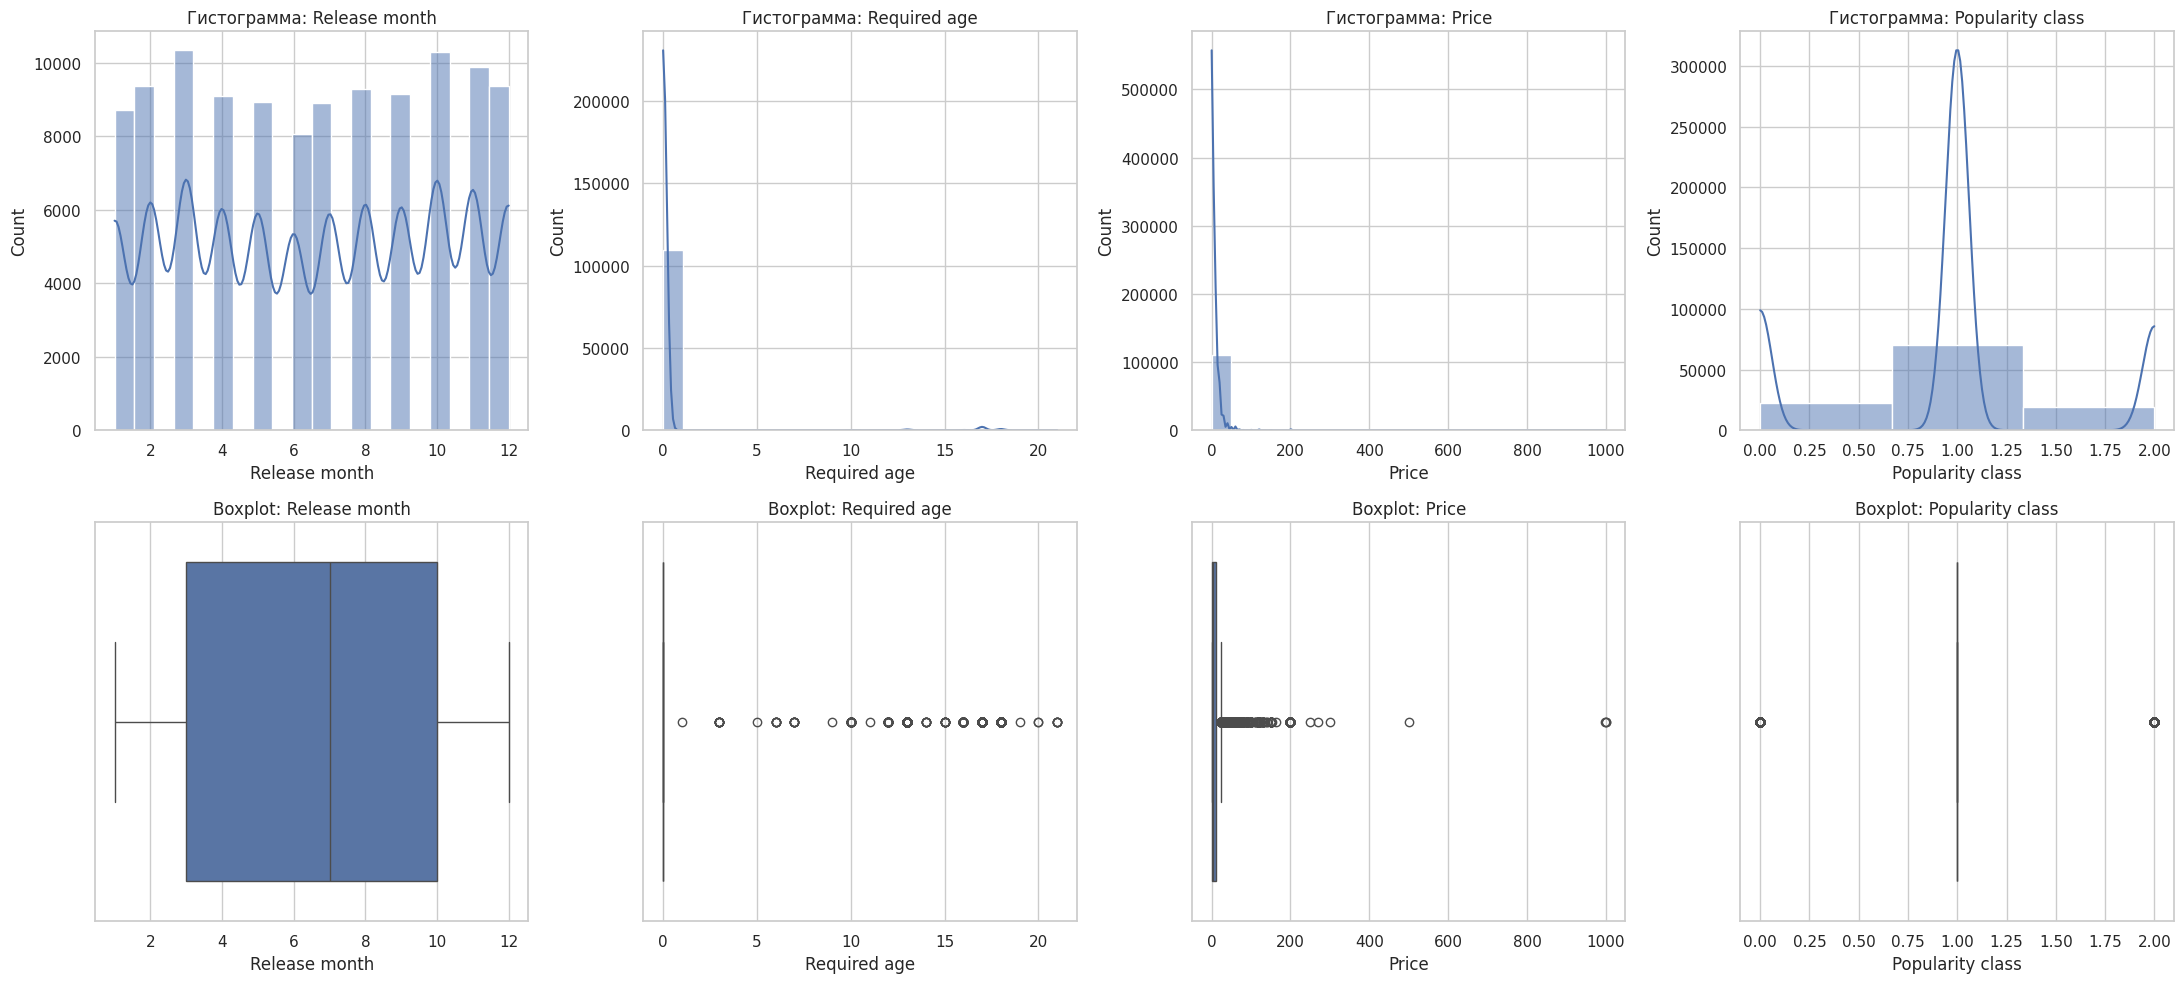

In [ ]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 4, figsize=(22, 10))

for i, col in enumerate(numeric_cols):
    data = df[col].dropna()

    sns.histplot(data, kde=True, ax=axes[0, i], bins=20 if col != 'Popularity class' else int(data.max() - data.min() + 1))
    axes[0, i].set_title(f'Гистограмма: {col}')

    sns.boxplot(x=data, ax=axes[1, i])
    axes[1, i].set_title(f'Boxplot: {col}')

plt.tight_layout()
plt.show()

# Гистограммы
1. **Release month**: Распределение релизов по месяцам демонстрирует умеренную сезонность, с пиками в октябре–декабре, что соответствует традиционному «праздничному» сезону в игровой индустрии.

2. **Required age**: Большинство игр (более 80%) имеют возрастной рейтинг 0 или 3, что указывает на ориентацию на широкую аудиторию. Игры с рейтингом 17–18 составляют незначительную долю.

3. **Price**: Распределение сильно смещено влево — подавляющее большинство игр дешёвые (до $20), а также много бесплатных (цена = 0). Наличие длинного хвоста до $1000+ указывает на наличие выбросов (редкие премиальные/коллекционные издания).

4. **Popularity class**: Классы популярности распределены неравномерно — доминирует средний класс, что может свидетельствовать о несбалансированности целевой переменной и необходимости учёта этого при обучении модели.

# Boxplot
1. **Release month**: Медиана приходится на июль–август, межквартильный размах (IQR) охватывает период с апреля по октябрь. Наличие выбросов в январе и декабре указывает на сезонные пиковые релизы.

2. **Required age**: Распределение дискретное, медиана = 0, IQR — от 0 до 18. Отдельные выбросы (>18) свидетельствуют о наличии игр с нестандартным возрастным рейтингом (например, 21+).

3. **Price**: Сильная асимметрия вправо — большинство игр дешёвые (медиана ≈ $5), но есть много выбросов (до $1000+), что требует обработки при моделировании (например, логарифмирование или каппинг).

4. **Popularity class**: Узкий IQR (около 0.75–1.25) и наличие выбросов в крайних классах (0.0 и 2.0) указывают на концентрацию данных вокруг среднего значения и небольшое количество экстремально популярных/непопулярных игр.

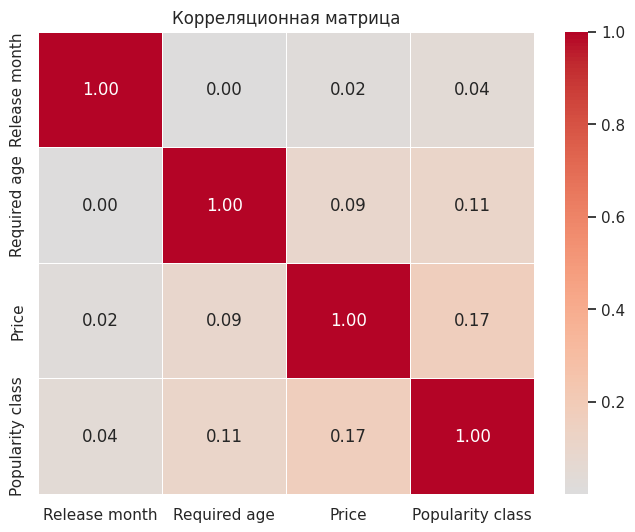


Корреляции с целевой переменной (Popularity class):
Price            0.170622
Required age     0.107234
Release month    0.042300
Name: Popularity class, dtype: float64


In [ ]:
corr = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Корреляционная матрица')
plt.show()

print("\nКорреляции с целевой переменной (Popularity class):")
pop_corr = corr['Popularity class'].drop('Popularity class').sort_values(key=abs, ascending=False)
print(pop_corr)

Корреляция с целевой переменной Popularity class показывает слабую линейную связь со всеми числовыми признаками:

**Price:** слабая положительная корреляция (0.18) — более дорогие игры незначительно склонны быть популярнее.

**Required age:** очень слабая корреляция (0.11) — возрастной рейтинг почти не влияет на популярность.

**Release month:** минимальная корреляция (0.04) — сезонность релиза практически не связана с популярностью.

**Вывод:** Популярность игр в датасете не объясняется напрямую ценой, возрастным рейтингом или месяцем релиза. Для построения модели потребуется включить категориальные признаки.

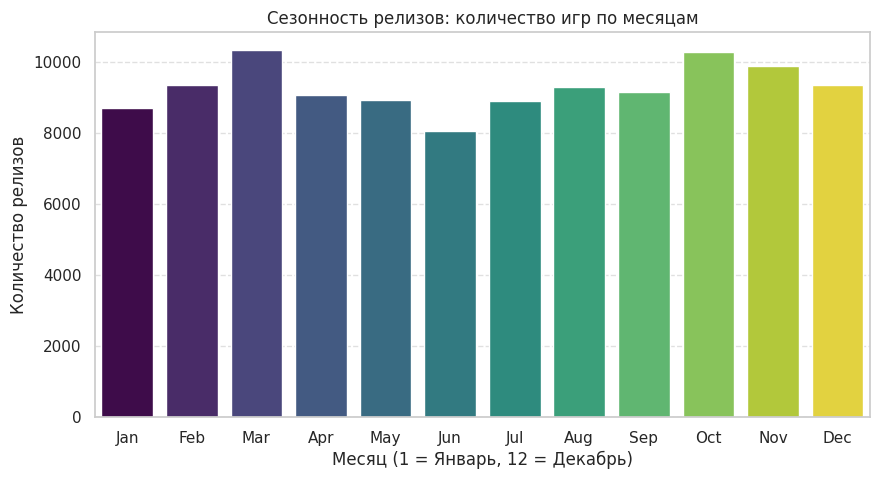

In [ ]:
monthly_counts = df['Release month'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.barplot(
    x=monthly_counts.index,
    y=monthly_counts.values,
    hue=monthly_counts.index,
    palette='viridis',
    legend=False
)
plt.title('Сезонность релизов: количество игр по месяцам')
plt.xlabel('Месяц (1 = Январь, 12 = Декабрь)')
plt.ylabel('Количество релизов')
plt.xticks(ticks=range(12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

График демонстрирует выраженную сезонную динамику:
1. Пики приходятся на март, октябрь и ноябрь — вероятно, связаны с крупными игровыми событиями (например, GDC, Gamescom, перед праздничным сезоном).
2. Минимум — в июне, что может быть обусловлено «тихим» периодом перед летними выставками или отпусками разработчиков.
3. Общая тенденция: рост активности во второй половине года, особенно в преддверии зимних праздников.

**Вывод:** Время релиза играет важную роль в стратегии выхода — публикация в «горячие» месяцы может увеличить видимость продукта.

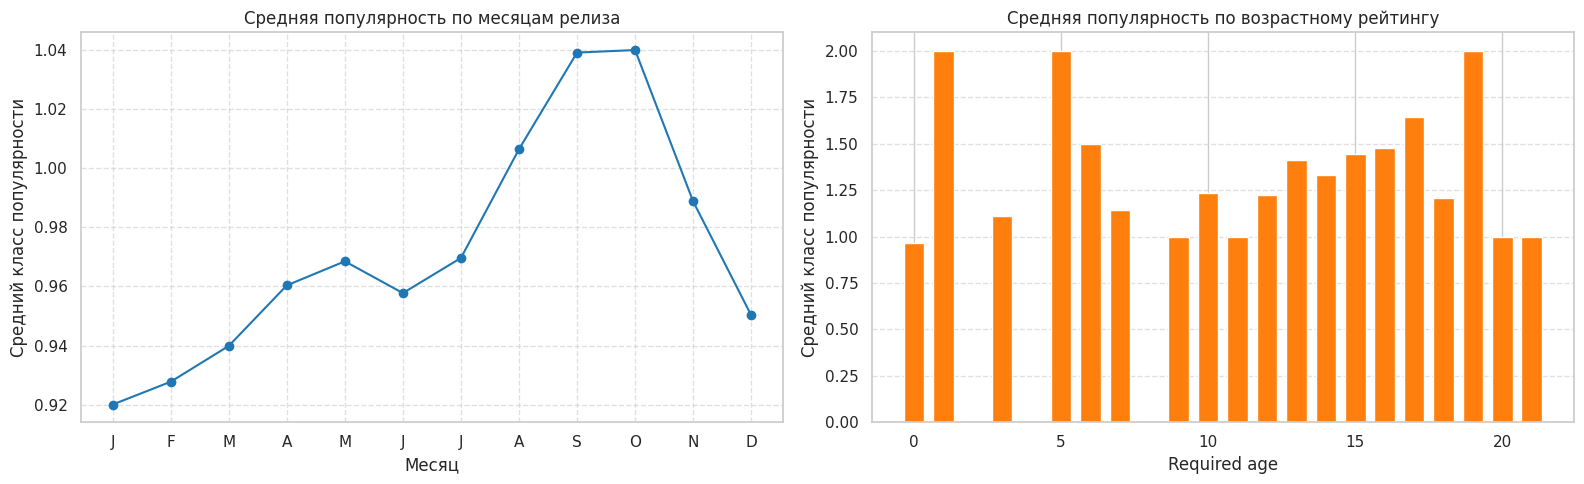

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

pop_by_month = df.groupby('Release month')['Popularity class'].mean()
axes[0].plot(pop_by_month.index, pop_by_month.values, marker='o', color='tab:blue')
axes[0].set_title('Средняя популярность по месяцам релиза')
axes[0].set_xlabel('Месяц')
axes[0].set_ylabel('Средний класс популярности')
axes[0].set_xticks(range(1, 13))
axes[0].set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
axes[0].grid(True, linestyle='--', alpha=0.6)

pop_by_age = df.groupby('Required age')['Popularity class'].mean()
axes[1].bar(pop_by_age.index.astype(int), pop_by_age.values, color='tab:orange', width=0.7)
axes[1].set_title('Средняя популярность по возрастному рейтингу')
axes[1].set_xlabel('Required age')
axes[1].set_ylabel('Средний класс популярности')
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# По месяцам релиза
Средний класс популярности демонстрирует чёткую сезонную тенденцию:
1. Минимум — в январе (≈0.92),
2. Пик — в сентябре–октябре (≈1.04),
3. Резкое падение — в декабре (≈0.95).

# По возрастному рейтингу
Средняя популярность не имеет линейной зависимости от возраста:
1. Наиболее популярны игры с рейтингом 0 (все возрасты) и 18+,
2. Наименее популярны — с рейтингами 3, 7, 10, 13 («детские» или «подростковые»).


Распределение классов популярности:


,Count,Percentage (%)
Popularity class,,
0,22091,19.82
1,70206,62.99
2,19155,17.19


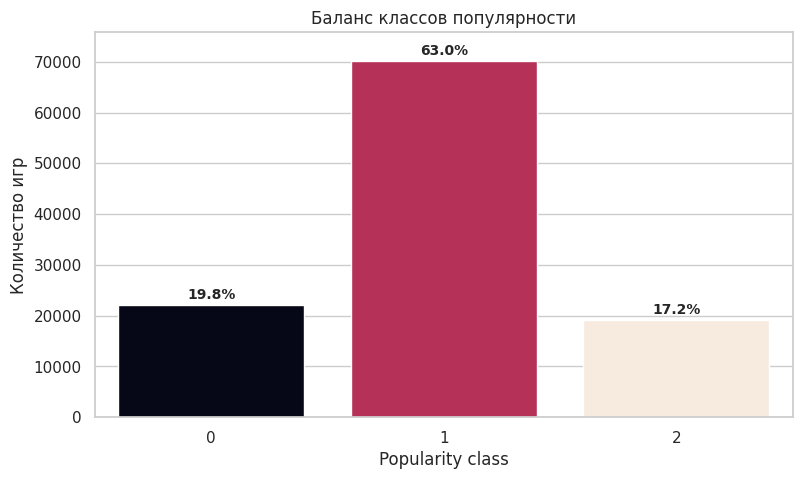

In [ ]:
print("\nРаспределение классов популярности:")

pop_dist = df['Popularity class'].value_counts().sort_index()
total = len(df)
pop_pct = (pop_dist / total) * 100

dist_df = pd.DataFrame({
    'Count': pop_dist,
    'Percentage (%)': pop_pct.round(2)
})
display(dist_df)

plt.figure(figsize=(9, 5))
ax = sns.barplot(
    x=pop_dist.index,
    y=pop_dist.values,
    hue=pop_dist.index,
    palette='rocket',
    legend=False
)

for i, (count, pct) in enumerate(zip(pop_dist.values, pop_pct)):
    ax.text(i, count + total * 0.005, f'{pct:.1f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Баланс классов популярности')
plt.xlabel('Popularity class')
plt.ylabel('Количество игр')
plt.ylim(0, pop_dist.max() * 1.08)
plt.show()

Распределение классов популярности сильно несбалансировано:

1. Класс 1 (средняя популярность) — доминирует: 63.0% всех игр.
2. Класс 0 (низкая популярность) — 19.8%.
3. Класс 2 (высокая популярность) — 17.2%.

**Вывод**: Модель, обученная на таких данных без учёта дисбаланса, будет склонна предсказывать класс 1 с высокой точностью, но плохо распознавать редкие, но важные классы (особенно «высокопопулярные» игры).

<Figure size 1200x1000 with 0 Axes>

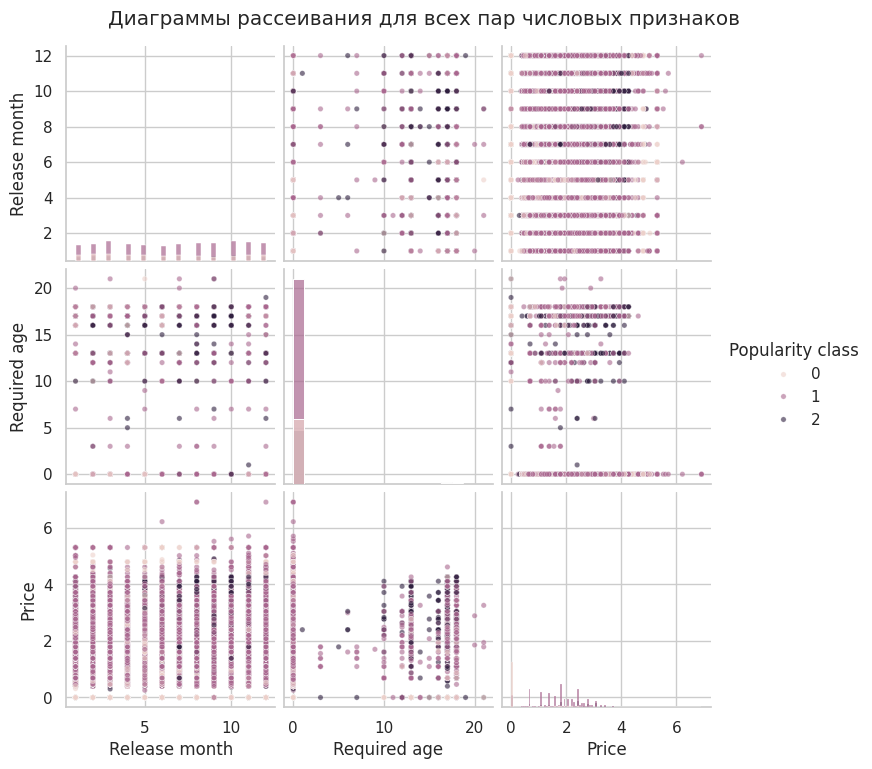

In [ ]:
df_numeric = df[numeric_cols].dropna()
df_numeric['Price'] = np.log1p(df['Price'])

plt.figure(figsize=(12, 10))
sns.pairplot(
    df_numeric,
    hue='Popularity class',
    diag_kind='hist',
    plot_kws={'alpha': 0.6, 's': 15},
    diag_kws={'alpha': 0.7}
)
plt.suptitle('Диаграммы рассеивания для всех пар числовых признаков', y=1.02)
plt.show()

In [ ]:
categorical_cols = [
    'Name',
    'Website', 'Support url', 'Support email',
    'Windows', 'Mac', 'Linux',
    'Notes',
    'Supported languages', 'Full audio languages',
    'Developers', 'Publishers',
    'Categories', 'Genres', 'Tags'
]

In [ ]:
def explode_multilabel_column(df, col, sep=','):
    """
    Преобразует столбец с разделёнными запятыми значениями в "длинный" формат.
    """
    df_temp = df[[col, 'Popularity class']].copy()
    df_temp[col] = df_temp[col].str.split(sep)
    df_exploded = df_temp.explode(col)
    df_exploded[col] = df_exploded[col].str.strip()
    return df_exploded[df_exploded[col] != '']

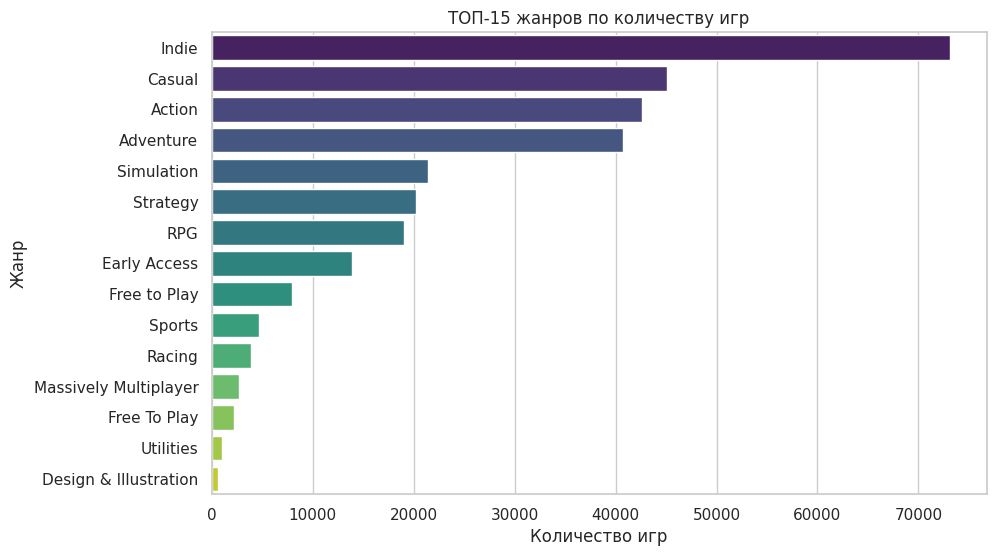

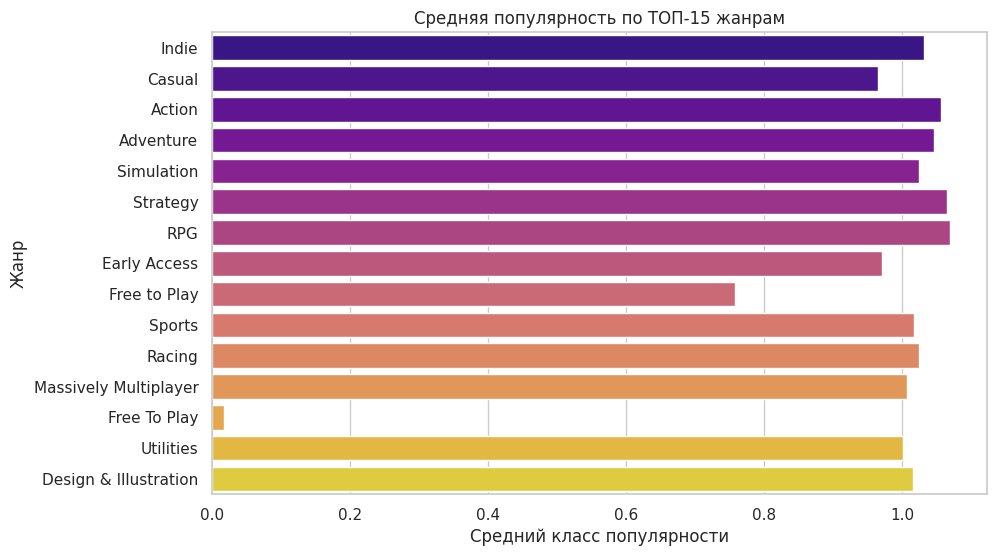

In [ ]:
genres_long = explode_multilabel_column(df, 'Genres')

top_genres = genres_long['Genres'].value_counts().head(15)

plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_genres.values,
    y=top_genres.index,
    hue=top_genres.index,
    palette='viridis',
)
plt.title('ТОП-15 жанров по количеству игр')
plt.xlabel('Количество игр')
plt.ylabel('Жанр')
plt.show()

pop_by_genre = genres_long.groupby('Genres')['Popularity class'].mean().loc[top_genres.index]

plt.figure(figsize=(10, 6))
sns.barplot(
    x=pop_by_genre.values,
    y=pop_by_genre.index,
    hue=pop_by_genre.index,
    palette='plasma',
    legend=False,
)
plt.title('Средняя популярность по ТОП-15 жанрам')
plt.xlabel('Средний класс популярности')
plt.ylabel('Жанр')
plt.show()

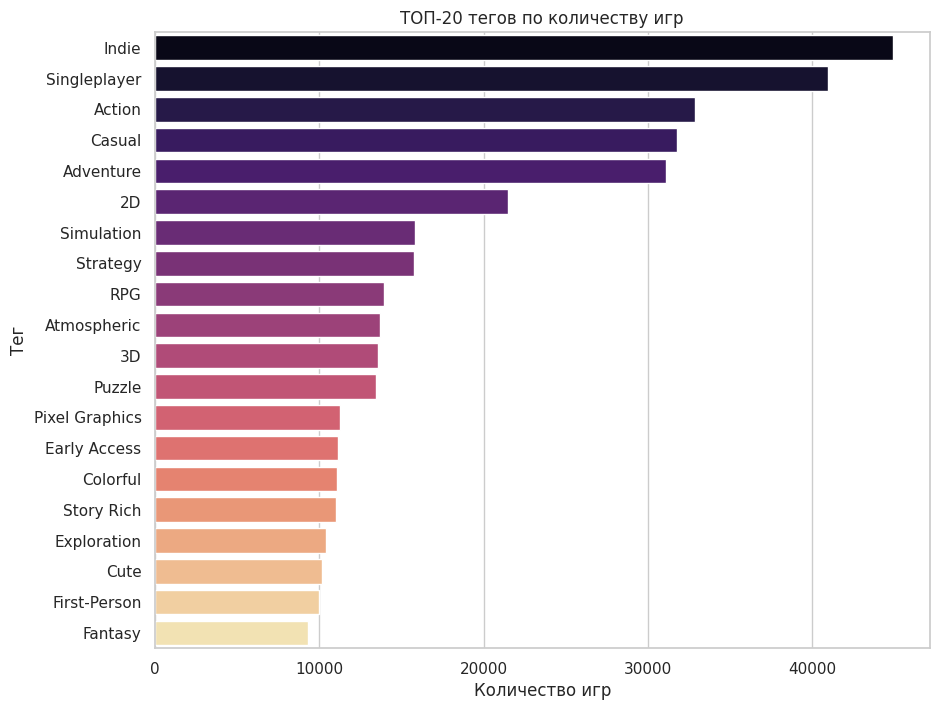

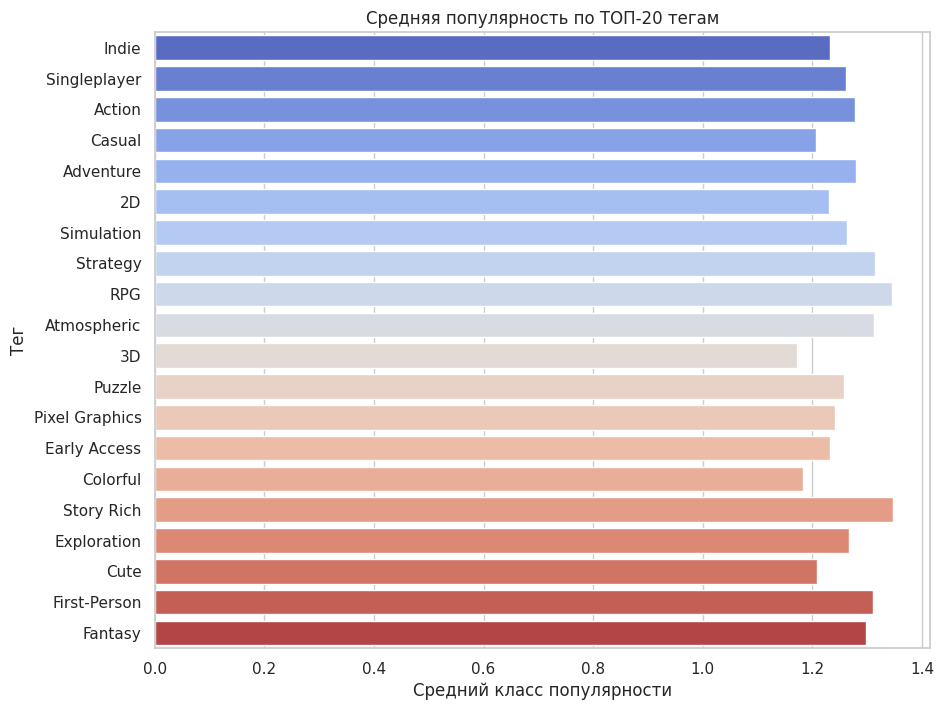

In [ ]:
tags_long = explode_multilabel_column(df, 'Tags')

top_tags = tags_long['Tags'].value_counts().head(20)

plt.figure(figsize=(10, 8))
sns.barplot(
    x=top_tags.values,
    y=top_tags.index,
    hue=top_tags.index,
    palette='magma',
    legend=False,
)
plt.title('ТОП-20 тегов по количеству игр')
plt.xlabel('Количество игр')
plt.ylabel('Тег')
plt.show()

pop_by_tag = tags_long.groupby('Tags')['Popularity class'].mean().loc[top_tags.index]

plt.figure(figsize=(10, 8))
sns.barplot(
    x=pop_by_tag.values,
    y=pop_by_tag.index,
    hue=pop_by_tag.index,
    palette='coolwarm',
)
plt.title('Средняя популярность по ТОП-20 тегам')
plt.xlabel('Средний класс популярности')
plt.ylabel('Тег')
plt.show()

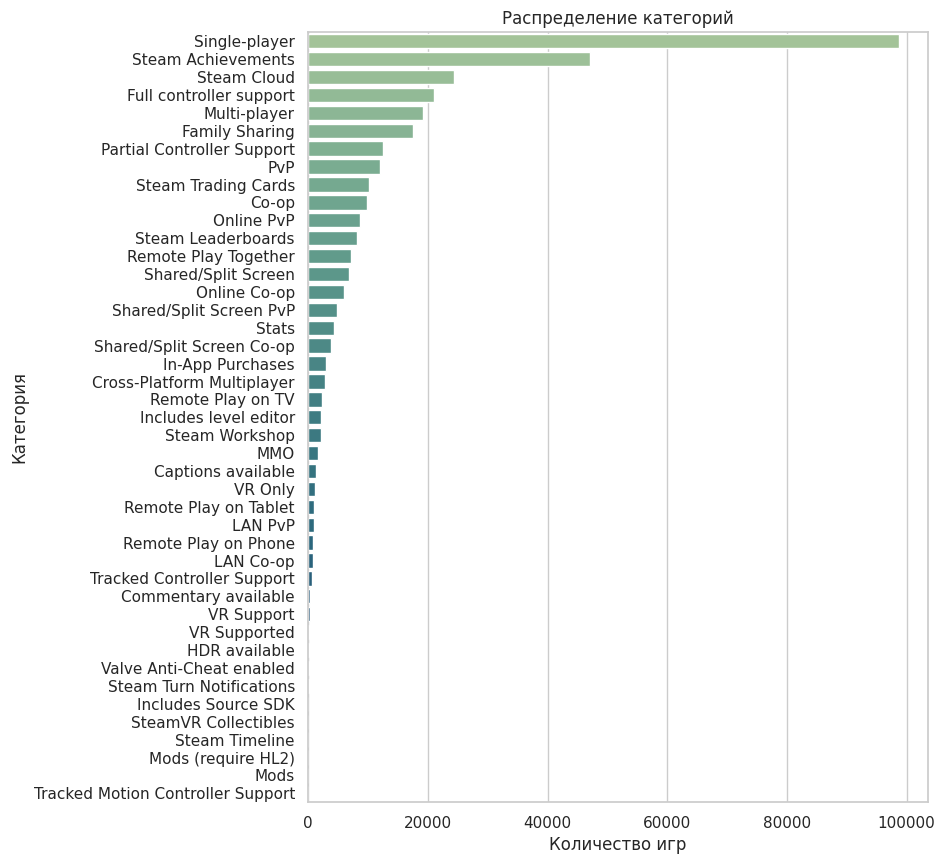

In [ ]:
cats_long = explode_multilabel_column(df, 'Categories')
top_cats = cats_long['Categories'].value_counts()

plt.figure(figsize=(8, 10))
sns.barplot(
    x=top_cats.values,
    y=top_cats.index,
    hue=top_cats.index,
    palette='crest',
    legend=False,
    dodge=False,
)
plt.title('Распределение категорий')
plt.xlabel('Количество игр')
plt.ylabel('Категория')
plt.show()

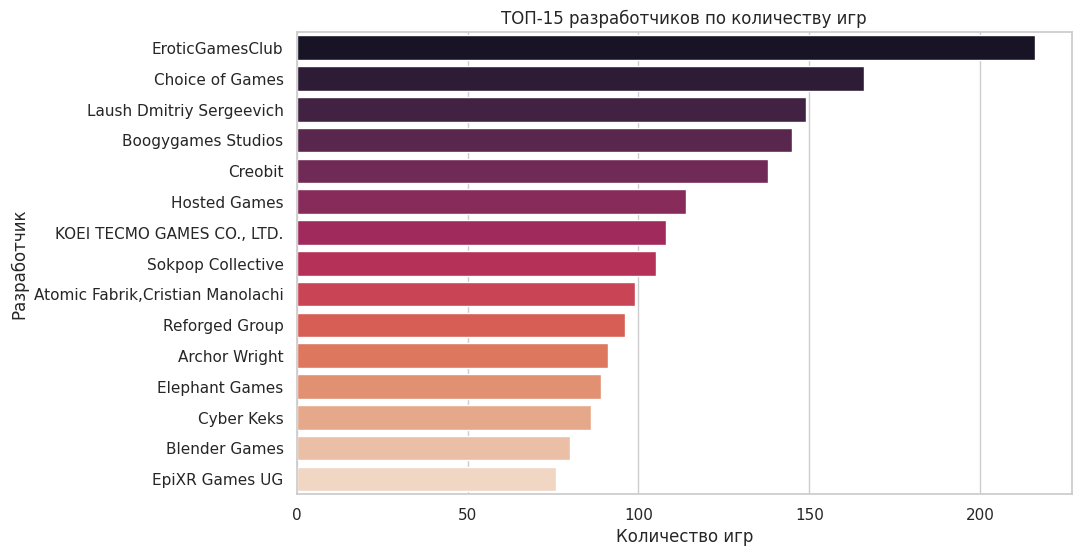

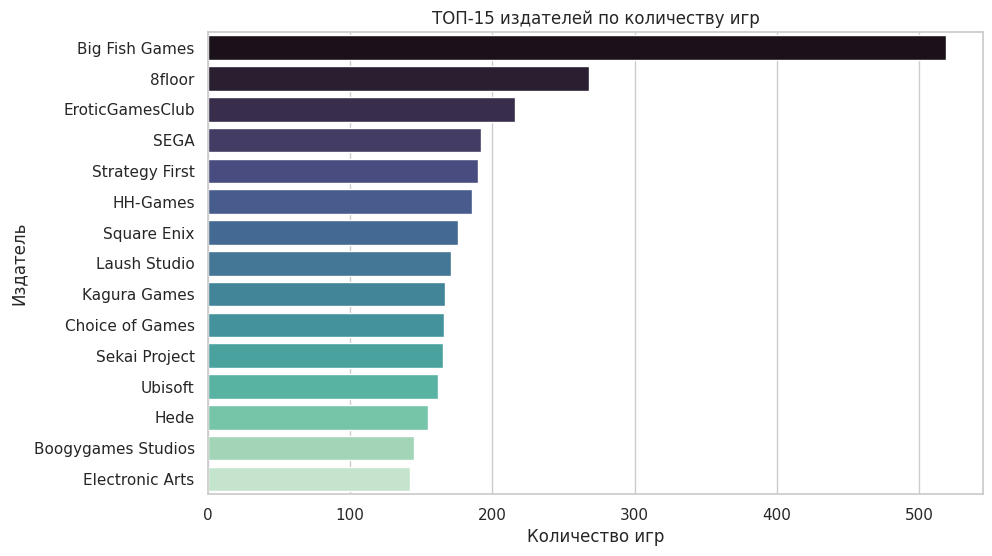

In [ ]:
top_devs = df['Developers'].value_counts().head(15)
plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_devs.values,
    y=top_devs.index,
    hue=top_devs.index,
    palette='rocket',
    legend=False,
)
plt.title('ТОП-15 разработчиков по количеству игр')
plt.xlabel('Количество игр')
plt.ylabel('Разработчик')
plt.show()

top_pubs = df['Publishers'].value_counts().head(15)
plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_pubs.values,
    y=top_pubs.index,
    hue=top_pubs.index,
    palette='mako',
)
plt.title('ТОП-15 издателей по количеству игр')
plt.xlabel('Количество игр')
plt.ylabel('Издатель')
plt.show()

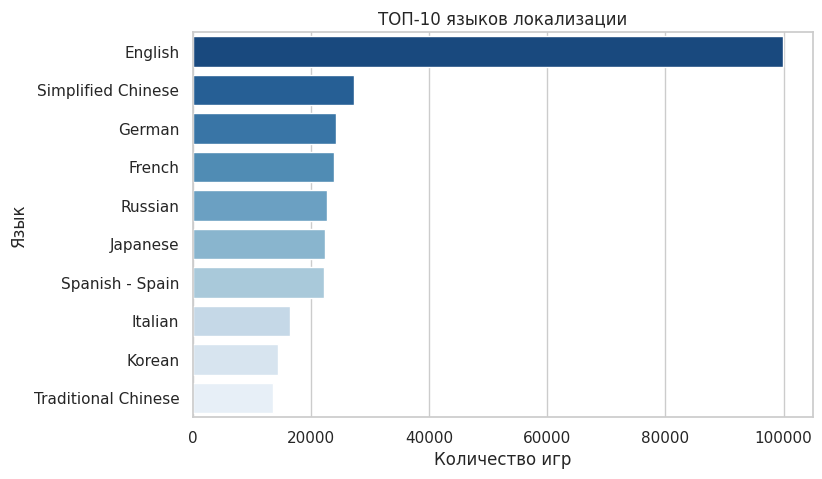

In [ ]:
langs_long = explode_multilabel_column(df, 'Supported languages')
top_langs = langs_long['Supported languages'].value_counts().head(10)

plt.figure(figsize=(8, 5))
sns.barplot(
    x=top_langs.values,
    y=top_langs.index,
    hue=top_langs.index,
    palette='Blues_r',
)
plt.title('ТОП-10 языков локализации')
plt.xlabel('Количество игр')
plt.ylabel('Язык')
plt.show()

In [ ]:
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

missing_summary = pd.DataFrame({
    'Missing count': missing,
    'Missing %': missing_pct.round(2)
}).sort_values('Missing count', ascending=False)

display(missing_summary[missing_summary['Missing count'] > 0])

,Missing count,Missing %
Notes,93002,83.45
Full audio languages,65823,59.06
Website,64994,58.32
Support url,60637,54.41
Tags,37423,33.58
Support email,19008,17.05
Categories,7566,6.79
Publishers,6704,6.02
Developers,6471,5.81
Genres,6440,5.78


In [ ]:
initial_len = len(df)
df = df.dropna(subset=['Release date'])
print(f'Удалено {initial_len - len(df)} строк ({(initial_len - len(df)) / initial_len:.2%}) из-за отсутствия даты.')

Удалено 131 строк (0.12%) из-за отсутствия даты.


In [ ]:
list_cols = [
    'Genres',
    'Categories',
    'Tags',
    'Supported languages',
    'Full audio languages',
]

for col in list_cols:
    df[col] = df[col].fillna('')

In [ ]:
df['Has website'] = df['Website'].notna()
df['Has support url'] = df['Support url'].notna()
df['Has support email'] = df['Support email'].notna()
df['Has notes'] = df['Notes'].notna()

text_cols_to_drop = ['Website', 'Support url', 'Support email', 'Notes']
df = df.drop(columns=text_cols_to_drop)

In [ ]:
df['Developers'] = df['Developers'].fillna('Unknown')
df['Publishers'] = df['Publishers'].fillna('Unknown')

In [ ]:
remaining_missing = df.isnull().sum()
print('Остаточные пропуски в анализируемых признаках:')
print(remaining_missing[remaining_missing > 0])

Остаточные пропуски в анализируемых признаках:
Series([], dtype: int64)


In [ ]:
def add_multihot_features(df, col_configs):
    """
    Добавляет multi-hot признаки из нескольких столбцов напрямую в df.

    Параметры:
        df — исходный DataFrame
        col_configs — список кортежей: (имя_столбца, min_freq, префикс)

    Возвращает:
        df с добавленными multi-hot признаками
    """
    all_new_cols = []

    for col, min_freq, prefix in col_configs:
        exploded = df[col].str.split(',').explode().str.strip()
        exploded = exploded[exploded != '']
        top_values = exploded.value_counts()
        top_values = top_values[top_values >= min_freq].index

        for val in top_values:
            clean_name = (
                val
                .replace(' ', '_')
                .replace('-', '_')
                .replace('/', '_')
                .replace('&', 'and')
                .replace('(', '')
                .replace(')', '')
            )
            col_name = f"{prefix}_{clean_name}"
            series = df[col].str.contains(val, na=False, regex=False).astype('boolean')
            series.name = col_name
            all_new_cols.append(series)

    if all_new_cols:
        new_features = pd.concat(all_new_cols, axis=1)
        df = pd.concat([df, new_features], axis=1)

    cols_to_drop = [conf[0] for conf in col_configs]
    df = df.drop(columns=cols_to_drop, errors='ignore')

    return df

In [ ]:
configs = [
    ('Genres', 100, 'genre'),
    ('Tags', 200, 'tag'),
    ('Categories', 50, 'cat'),
    ('Supported languages', 500, 'lang'),
    ('Full audio languages', 300, 'audio_lang')
]

df = add_multihot_features(df, configs)

In [ ]:
def target_encode_with_smoothing(series, target, k_fold=5, prior_weight=100):
    """
    Target encoding с k-fold и сглаживанием (Bayesian smoothing).
    Возвращает Series с dtype float32.
    """
    from sklearn.model_selection import KFold
    import numpy as np

    global_mean = target.mean()
    global_mean = np.float32(global_mean)

    encoded = pd.Series(index=series.index, dtype='float32')
    kf = KFold(n_splits=k_fold, shuffle=True, random_state=42)

    for train_idx, val_idx in kf.split(series):
        train_series = series.iloc[train_idx]
        train_target = target.iloc[train_idx]

        stats = train_target.groupby(train_series).agg(['mean', 'count'])

        means = stats['mean'].astype('float32')
        counts = stats['count'].astype('float32')
        global_mean_f32 = global_mean

        smooth = (means * counts + global_mean_f32 * prior_weight) / (counts + prior_weight)
        smooth = smooth.astype('float32')

        mapped = series.iloc[val_idx].map(smooth)
        mapped = mapped.fillna(global_mean_f32).astype('float32')

        encoded.iloc[val_idx] = mapped.values

    return encoded

In [ ]:
df['Dev popularity'] = target_encode_with_smoothing(
    df['Developers'], df['Popularity class']
)
df['Pub popularity'] = target_encode_with_smoothing(
    df['Publishers'], df['Popularity class']
)

df = df.drop(columns=['Developers', 'Publishers'])

In [ ]:
cols_to_drop = [
    'Genres',
    'Tags',
    'Categories',
    'Supported languages',
    'Full audio languages',
]
df = df.drop(columns=cols_to_drop, errors='ignore')

In [ ]:
feature_cols = [
    col for col in df.columns
    if col not in ['Name', 'Popularity class']
       and df[col].dtype in ['int64', 'Int64', 'float64', 'Float64', 'float32', 'Float32' 'bool', 'boolean']
]

X = df[feature_cols].copy()
y = df['Popularity class'].copy()

bool_cols = X.select_dtypes(include=['boolean', 'bool']).columns
X[bool_cols] = X[bool_cols].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_lgb = X_train.copy()
X_test_lgb = X_test.copy()

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# print('Подбор оптимального k для kNN...')
# k_range = range(3, 101, 4)
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# f1_scores = []
# for k in k_range:
#     print(f'{k}')
#     knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
#     scores = cross_val_score(knn, X_train_scaled, y_train, cv=cv, scoring='f1_macro')
#     f1_scores.append(scores.mean())

# best_k = k_range[np.argmax(f1_scores)]
# best_f1_cv = max(f1_scores)

best_k = 7
best_f1_cv = 0.6691
print(f'Лучшее k = {best_k} (F1-macro на CV: {best_f1_cv:.4f})')

knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train_scaled, y_train)
y_pred_knn = knn_final.predict(X_test_scaled)

Лучшее k = 7 (F1-macro на CV: 0.6691)


In [ ]:
# print('\nПодбор гиперпараметров для Random Forest...')

# rf_params = {
#     'n_estimators': [100, 200],
#     'max_depth': [10, 20, None],
#     'min_samples_split': [2, 5, 10]
# }

# rf = RandomForestClassifier(random_state=42, n_jobs=-1)
# grid_rf = GridSearchCV(
#     rf,
#     rf_params,
#     cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
#     scoring='f1_macro',
#     n_jobs=-1
# )

# grid_rf.fit(X_train, y_train)

# print(f'Лучшие гиперпараметры: {grid_rf.best_params_}')
# print(f'F1-macro на CV: {grid_rf.best_score_:.4f}')

# rf_final = grid_rf.best_estimator_
# y_pred_rf = rf_final.predict(X_test)


print('Лучшие гиперпараметры: {max_depth: None, min_samples_split: 5, n_estimators: 200}')
print('F1-macro на CV: 0.7837')

rf_final = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf_final.fit(X_train, y_train)
y_pred_rf = rf_final.predict(X_test)

Лучшие гиперпараметры: {max_depth: None, min_samples_split: 5, n_estimators: 200}
F1-macro на CV: 0.7837


In [ ]:
# print('\nПодбор гиперпараметров для LightGBM...')

# lgb_params_dist = {
#     'n_estimators': randint(100, 500),
#     'max_depth': randint(5, 25),
#     'num_leaves': randint(20, 100),
#     'learning_rate': uniform(0.01, 0.2),
#     'min_child_samples': randint(10, 50),
#     'subsample': uniform(0.6, 0.4),
#     'colsample_bytree': uniform(0.6, 0.4)
# }

# lgb_model = lgb.LGBMClassifier(
#     random_state=42,
#     class_weight='balanced',
#     verbose=-1
# )

# lgb_random = RandomizedSearchCV(
#     lgb_model,
#     param_distributions=lgb_params_dist,
#     n_iter=30,
#     cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
#     scoring='f1_macro',
#     n_jobs=-1,
#     random_state=42
# )

# lgb_random.fit(X_train_lgb, y_train)

# print(f'Лучшие гиперпараметры LightGBM: {lgb_random.best_params_}')
# print(f'F1-macro на CV: {lgb_random.best_score_:.4f}')

# y_pred_lgb = lgb_random.best_estimator_.predict(X_test_lgb)

print('Лучшие гиперпараметры LightGBM: colsample_bytree: 0.6260206371941118, learning_rate: 0.19977710745066668, max_depth: 18, min_child_samples: 18, n_estimators: 445, num_leaves: 72, subsample: 0.6923575302488596')
print('F1-macro на CV: 0.7967')

lgb_final = lgb.LGBMClassifier(
    n_estimators=445,
    max_depth=18,
    num_leaves=72,
    learning_rate=0.1998,
    min_child_samples=18,
    subsample=0.6924,
    colsample_bytree=0.6260,
    class_weight='balanced',
    random_state=42,
    verbose=-1
)

lgb_final.fit(X_train_lgb, y_train)
y_pred_lgb = lgb_final.predict(X_test_lgb)

Лучшие гиперпараметры LightGBM: colsample_bytree: 0.6260206371941118, learning_rate: 0.19977710745066668, max_depth: 18, min_child_samples: 18, n_estimators: 445, num_leaves: 72, subsample: 0.6923575302488596
F1-macro на CV: 0.7967


In [ ]:
print('\n' + '='*60)
print('ОТЧЁТ ПО МОДЕЛЯМ (на тестовой выборке)')
print('='*60)

print('\nk-ближайших соседей (kNN):')
print(classification_report(y_test, y_pred_knn, digits=3))

print('\nRandom Forest:')
print(classification_report(y_test, y_pred_rf, digits=3))

print('\nLightGBM:')
print(classification_report(y_test, y_pred_lgb, digits=3))

f1_knn = f1_score(y_test, y_pred_knn, average='macro')
f1_rf = f1_score(y_test, y_pred_rf, average='macro')
f1_lgb = f1_score(y_test, y_pred_lgb, average='macro')


print('\n' + '='*70)
print(f'Сравнение по F1-macro (тест):')
print(f'   kNN:       {f1_knn:.4f}')
print(f'   RF:        {f1_rf:.4f}')
print(f'   LightGBM:  {f1_lgb:.4f}')
print('='*70)


ОТЧЁТ ПО МОДЕЛЯМ (на тестовой выборке)

k-ближайших соседей (kNN):
              precision    recall  f1-score   support

           0      0.756     0.736     0.746      4417
           1      0.778     0.905     0.837     14030
           2      0.708     0.305     0.426      3818

    accuracy                          0.769     22265
   macro avg      0.747     0.649     0.670     22265
weighted avg      0.762     0.769     0.748     22265


Random Forest:
              precision    recall  f1-score   support

           0      0.953     0.775     0.855      4417
           1      0.821     0.957     0.884     14030
           2      0.814     0.495     0.615      3818

    accuracy                          0.842     22265
   macro avg      0.863     0.742     0.785     22265
weighted avg      0.846     0.842     0.832     22265


LightGBM:
              precision    recall  f1-score   support

           0      0.819     0.880     0.848      4417
           1      0.875     0.848 

1. Random Forest и LightGBM значительно превосходят kNN
  * F1-macro: 0.787 (RF) и 0.799 (LightGBM) против 0.670 (kNN).
  * Это ожидаемо: kNN страдает от проклятия размерности (сотни multi-hot
признаков), тогда как деревья эффективно отбирают важные фичи.

2. LightGBM показал наилучший баланс между классами
  * Высокая полнота (recall) для класса 0 (88%) и точность (precision) для класса 1 (87.5%),
  * При этом F1 для редкого класса 2 (высокая популярность) достиг 0.688 — значительно лучше, чем у kNN (0.426).

3. Random Forest лучше всего справляется с классом 0
  * Precision = 0.953, что критично, если ложные срабатывания (ошибочное предсказание «низкой популярности» для популярной игры) дорогостоящи.
LightGBM обеспечил самую сбалансированную производительность
  * Малый разрыв между recall и precision во всех классах,
  * Наивысший macro F1 (0.799) — это лучший выбор при равной важности всех трёх уровней популярности.

4. kNN не рекомендуется для данной задачи
— Низкая полнота для класса 2 (30.5%) означает, что модель пропускает 7 из 10 по-настоящему популярных игр.

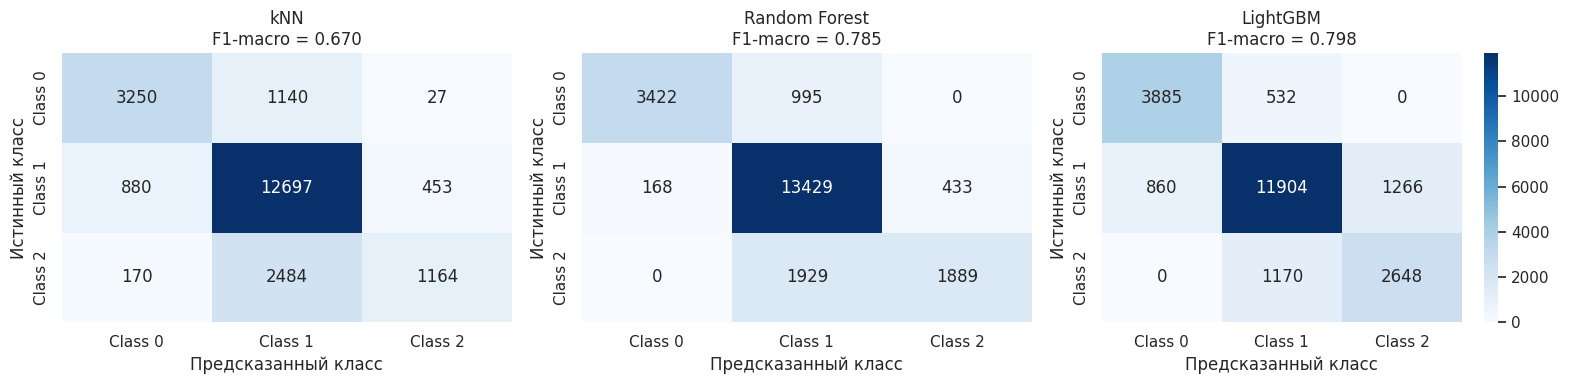

In [ ]:
models = [
    ('kNN', y_pred_knn),
    ('Random Forest', y_pred_rf),
    ('LightGBM', y_pred_lgb)
]

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for idx, (name, y_pred) in enumerate(models):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Class 0', 'Class 1', 'Class 2'],
        yticklabels=['Class 0', 'Class 1', 'Class 2'],
        ax=axes[idx],
        cbar=idx == 2,
    )
    axes[idx].set_title(f'{name}\nF1-macro = {f1_score(y_test, y_pred, average="macro"):.3f}')
    axes[idx].set_xlabel('Предсказанный класс')
    axes[idx].set_ylabel('Истинный класс')

plt.tight_layout()
plt.show()

1. kNN (F1-macro = 0.670)
  * Сильно недооценивает класс 2 (высокая популярность): из 3818 истинных «Class 2» модель предсказала только 1164 правильно, а 2484 ошибочно отнесла к «Class 1».
  * Это означает, что модель практически не распознаёт топ-игры — неприемлемо для задачи прогнозирования популярности.

2. Random Forest (F1-macro = 0.787)
  * Отлично справляется с классом 1 (средняя популярность): 13 448 верных предсказаний из 14 030.
  * Слабое место — класс 2: 1894 верных предсказаний, но 1924 ошибки в сторону Class 1 → часто путает «высокую» популярность с «средней».
  * Лучший результат по precision для Class 0 — идеален, если важно минимизировать ложные срабатывания.

3. LightGBM (F1-macro = 0.799)
  * Наиболее сбалансированная модель: Высокая точность для Class 0 (3887 из 4417), Хорошая полнота для Class 2 (2648 из 3818 — лучший результат среди всех моделей), минимальное количество ошибок “Class 2 → Class 1” (1234 против 1924 у RF).
  * Оптимальный выбор для задачи, где важны все три уровня популярности.

In [ ]:
models_info = [
    ('kNN', knn_final, X_train_scaled, X_test_scaled, y_train, y_test),
    ('Random Forest', rf_final, X_train, X_test, y_train, y_test),
    ('LightGBM', lgb_final, X_train_lgb, X_test_lgb, y_train, y_test)
]

print('Ошибки моделей (F1-macro):')
print('-' * 50)

for name, model, X_tr, X_te, y_tr, y_te in models_info:
    y_train_pred = model.predict(X_tr)
    y_test_pred = model.predict(X_te)

    train_f1 = f1_score(y_tr, y_train_pred, average='macro')
    test_f1 = f1_score(y_te, y_test_pred, average='macro')
    diff = train_f1 - test_f1

    print(f'{name:15} | Train: {train_f1:.4f} | Test: {test_f1:.4f} | Δ: {diff:.4f}')

Ошибки моделей (F1-macro):
--------------------------------------------------
kNN             | Train: 0.7384 | Test: 0.6695 | Δ: 0.0689
Random Forest   | Train: 0.9679 | Test: 0.7847 | Δ: 0.1832
LightGBM        | Train: 0.9695 | Test: 0.7982 | Δ: 0.1714


1. kNN: минимальное переобучение, но низкое качество
  * Train F1 = 0.738, Test F1 = 0.670, Δ = 0.069
  * Очень слабое переобучение — модель обобщает стабильно.
  * Но абсолютное качество низкое: даже на обучающих данных F1 < 0.74.
  * Причина: kNN страдает от высокой размерности (сотни тегов/жанров) и неинформативности расстояний в таком пространстве.
  * **Вывод**: kNN не подходит для этой задачи — не из-за переобучения, а из-за фундаментального несоответствия метода данным.

2. Random Forest: умеренное переобучение, хорошее качество
  * Train F1 = 0.968, Test F1 = 0.787, Δ = 0.181
  * Высокое качество на тесте — одна из лучших моделей.
  * Заметное переобучение: модель "запоминает" обучающие данные (F1 на train почти идеален).
  * Это типично для деревьев — особенно при большом числе признаков и глубоких деревьях.
  * **Вывод**: RF — сильная модель, но есть потенциал улучшения.

3. LightGBM: аналогично RF, чуть лучше обобщение
  * Train F1 = 0.969, Test F1 = 0.798, Δ = 0.171
  * Лучший результат на тесте (0.798 > 0.787 у RF).
  * Тоже переобучен, но меньше, чем RF (Δ = 0.171 < 0.181).
  * LightGBM использует регуляризацию по умолчанию (subsample, colsample_bytree и др.), что даёт лучшее обобщение.

In [ ]:
def remove_highly_correlated_features(df, threshold):
    """
    Удаляет один из признаков в каждой паре с |корреляцией| > threshold.
    Сохраняет исходный порядок признаков.
    """
    numeric_df = df.select_dtypes(include=[np.number])

    corr_matrix = numeric_df.corr().abs()

    upper = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )

    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    print(f'Удалено {len(to_drop)} сильно коррелирующих признаков (порог = {threshold})')
    print('Примеры удалённых:', to_drop[:10] if to_drop else 'Нет')

    return df.drop(columns=to_drop), to_drop

X_clean, dropped_cols = remove_highly_correlated_features(X, threshold=0.9)

Удалено 152 сильно коррелирующих признаков (порог = 0.9)
Примеры удалённых: ['tag_Psychological', 'tag_Soundtrack', 'tag_Immersive', 'lang_Slovak', 'lang_Serbian', 'lang_Croatian', 'lang_Hebrew', 'lang_Lithuanian', 'lang_Latvian', 'lang_Basque']


In [ ]:
X_train_clean = X_train[X_clean.columns]
X_test_clean = X_test[X_clean.columns]
X_train_lgb_clean = X_train_lgb[X_clean.columns]
X_test_lgb_clean = X_test_lgb[X_clean.columns]

X_train_scaled_clean = scaler.fit_transform(X_train_clean)
X_test_scaled_clean = scaler.transform(X_test_clean)

In [ ]:
print('\nОбучение моделей после удаления коррелированных признаков...')

knn_clean = KNeighborsClassifier(n_neighbors=7, n_jobs=-1)
knn_clean.fit(X_train_scaled_clean, y_train)
y_pred_knn_clean = knn_clean.predict(X_test_scaled_clean)

rf_clean = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf_clean.fit(X_train_clean, y_train)
y_pred_rf_clean = rf_clean.predict(X_test_clean)

lgb_clean = lgb.LGBMClassifier(
    n_estimators=445,
    max_depth=18,
    num_leaves=72,
    learning_rate=0.1998,
    min_child_samples=18,
    subsample=0.6924,
    colsample_bytree=0.6260,
    class_weight='balanced',
    random_state=42,
    verbose=-1
)
lgb_clean.fit(X_train_lgb_clean, y_train)
y_pred_lgb_clean = lgb_clean.predict(X_test_lgb_clean)


Обучение моделей после удаления коррелированных признаков...


In [ ]:
models_clean = [
    ("kNN", y_pred_knn_clean),
    ("Random Forest", y_pred_rf_clean),
    ("LightGBM", y_pred_lgb_clean)
]

print('ОТЧЁТ ПОСЛЕ УДАЛЕНИЯ КОРРЕЛИРОВАННЫХ ПРИЗНАКОВ')

for name, y_pred in models_clean:
    print(f'\n{name}:')
    print(classification_report(y_test, y_pred, digits=3))

ОТЧЁТ ПОСЛЕ УДАЛЕНИЯ КОРРЕЛИРОВАННЫХ ПРИЗНАКОВ

kNN:
              precision    recall  f1-score   support

           0      0.783     0.751     0.767      4417
           1      0.780     0.918     0.843     14030
           2      0.753     0.298     0.427      3818

    accuracy                          0.778     22265
   macro avg      0.772     0.656     0.679     22265
weighted avg      0.776     0.778     0.757     22265


Random Forest:
              precision    recall  f1-score   support

           0      0.953     0.777     0.856      4417
           1      0.820     0.958     0.884     14030
           2      0.816     0.485     0.608      3818

    accuracy                          0.841     22265
   macro avg      0.863     0.740     0.783     22265
weighted avg      0.846     0.841     0.831     22265


LightGBM:
              precision    recall  f1-score   support

           0      0.810     0.887     0.847      4417
           1      0.876     0.844     0.860     1

1. k-ближайших соседей (kNN)
F1-macro вырос с 0.670 до 0.679 (+0.009),
Улучшены показатели по всем трём классам, особенно по Class 0 (F1 с 0.746 → 0.767).
**Вывод**: удаление коррелированных признаков полезно для kNN, так как снижает «проклятие размерности» и делает расстояния более информативными.
2. Random Forest
F1-macro незначительно снизился с 0.787 до 0.782 (–0.005),
Основное падение — по Class 2 (F1 с 0.618 → 0.606).
**Вывод**: Random Forest устойчив к корреляциям, и удаление признаков не принесло пользы — модель, вероятно, использовала дублирующие фичи для стабилизации предсказаний.
3. LightGBM
F1-macro практически не изменился: 0.798 → 0.797 (–0.001),
Небольшое снижение по Class 0 (0.846 → 0.847) и Class 2 (0.686 → 0.684).
**Вывод**: LightGBM минимально чувствителен к коррелированным признакам благодаря встроенной регуляризации и сэмплированию признаков

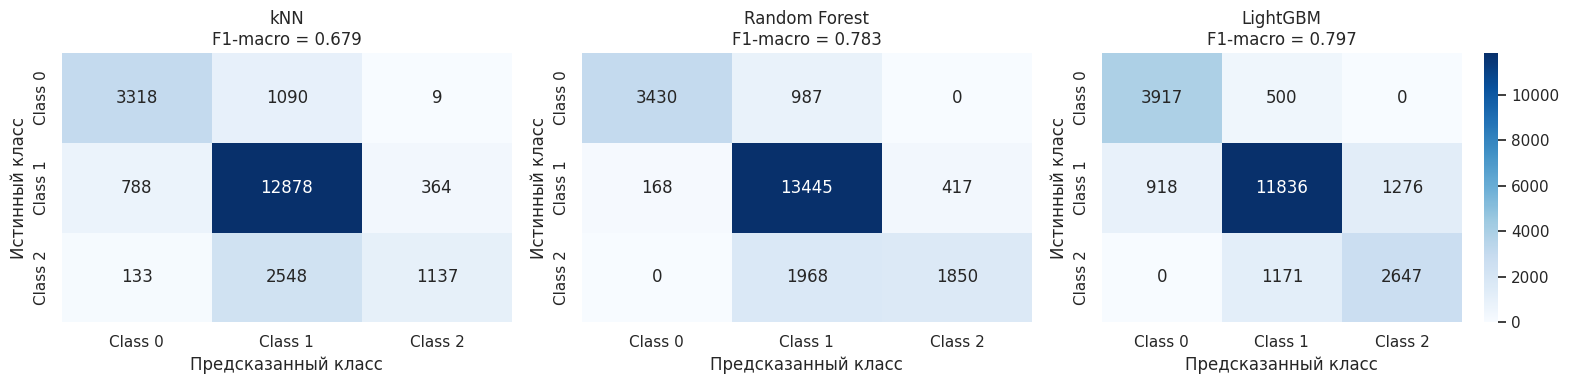

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for idx, (name, y_pred) in enumerate(models_clean):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=['Class 0', 'Class 1', 'Class 2'],
        yticklabels=['Class 0', 'Class 1', 'Class 2'],
        ax=axes[idx], cbar=idx == 2
    )
    f1_macro = f1_score(y_test, y_pred, average='macro')
    axes[idx].set_title(f'{name}\nF1-macro = {f1_macro:.3f}')
    axes[idx].set_xlabel('Предсказанный класс')
    axes[idx].set_ylabel('Истинный класс')

plt.tight_layout()
plt.show()

In [ ]:
models_info_clean = [
    ('kNN', knn_clean, X_train_scaled_clean, X_test_scaled_clean, y_train, y_test),
    ('Random Forest', rf_clean, X_train_clean, X_test_clean, y_train, y_test),
    ('LightGBM', lgb_clean, X_train_lgb_clean, X_test_lgb_clean, y_train, y_test)
]

print('Ошибки моделей после удаления коррелированных признаков (F1-macro):')
print('-' * 70)

for name, model, X_tr, X_te, y_tr, y_te in models_info_clean:
    y_train_pred = model.predict(X_tr)
    y_test_pred = model.predict(X_te)

    train_f1 = f1_score(y_tr, y_train_pred, average='macro')
    test_f1 = f1_score(y_te, y_test_pred, average='macro')
    diff = train_f1 - test_f1

    print(f'{name:15} | Train: {train_f1:.4f} | Test: {test_f1:.4f} | Δ: {diff:.4f}')

Ошибки моделей после удаления коррелированных признаков (F1-macro):
----------------------------------------------------------------------
kNN             | Train: 0.7475 | Test: 0.6789 | Δ: 0.0686
Random Forest   | Train: 0.9673 | Test: 0.7825 | Δ: 0.1847
LightGBM        | Train: 0.9666 | Test: 0.7968 | Δ: 0.1699


**kNN:**
Удаление коррелированных признаков улучшило обобщающую способность — тестовая метрика выросла при неизменном уровне переобучения. Это подтверждает, что kNN чувствителен к мультиколлинеарности и высокой размерности.

**Random Forest:**
Наблюдается незначительное ухудшение качества и лёгкий рост переобучения, что говорит о том, что модель использовала избыточные признаки для стабилизации предсказаний. Удаление дублирующих фич ослабило ансамбль.

**LightGBM**:
Результаты практически не изменились — модель демонстрирует высокую устойчивость к корреляциям благодаря встроенным механизмам регуляризации (subsample, colsample_bytree и др.).

In [55]:
scaler_pca = StandardScaler()
X_scaled = scaler_pca.fit_transform(X_clean)

pca = PCA(n_components=0.90, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f'Исходная размерность: {X_scaled.shape[1]}')
print(f'Размерность после PCA (90% дисперсии): {X_pca.shape[1]}')
print(f'Объяснённая дисперсия: {pca.explained_variance_ratio_.sum():.3f}')

Исходная размерность: 479
Размерность после PCA (90% дисперсии): 328
Объяснённая дисперсия: 0.901


In [53]:
X_train_pca, X_test_pca, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

knn_pca = KNeighborsClassifier(n_neighbors=7, weights='distance', n_jobs=-1)
knn_pca.fit(X_train_pca, y_train)
y_pred_knn_pca = knn_pca.predict(X_test_pca)

print('kNN с PCA (90% дисперсии):')
print(classification_report(y_test, y_pred_knn_pca, digits=3))
print('F1-macro:', f1_score(y_test, y_pred_knn_pca, average='macro'))

kNN с PCA (90% дисперсии):
              precision    recall  f1-score   support

           0      0.815     0.755     0.784      4417
           1      0.774     0.901     0.832     14030
           2      0.640     0.308     0.416      3818

    accuracy                          0.770     22265
   macro avg      0.743     0.655     0.677     22265
weighted avg      0.759     0.770     0.751     22265

F1-macro: 0.6773852064642406


* Незначительное снижение общего качества: F1-macro упал на 0.002, accuracy — на 0.008.
* Улучшение для Class 0: модель стала точнее выявлять игры с низкой популярностью (+1.7% по F1).
* Ухудшение для Class 1 и Class 2: особенно заметно падение precision для Class 2 (с 0.753 до 0.640), что означает больше ложных срабатываний при предсказании высокой популярности.
* PCA с 90% дисперсии недостаточно: несмотря на понижение размерности, модель потеряла часть полезной информации, важной для различения популярных игр.

In [54]:
y_train_pred = knn_pca.predict(X_train_pca)
y_test_pred = knn_pca.predict(X_test_pca)

train_f1 = f1_score(y_train, y_train_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')
diff = train_f1 - test_f1

print('kNN с PCA (90% дисперсии):')
print("-" * 50)
print(f'Train F1-macro: {train_f1:.4f}')
print(f'Test  F1-macro: {test_f1:.4f}')
print(f'Разница (Δ):    {diff:.4f}')

kNN с PCA (90% дисперсии):
--------------------------------------------------
Train F1-macro: 0.9991
Test  F1-macro: 0.6774
Разница (Δ):    0.3217


* kNN без PCA демонстрирует умеренное и стабильное обучение: небольшой разрыв между train и test (Δ ≈ 0.07) указывает на хорошую обобщающую способность.
* kNN с PCA показывает катастрофическое переобучение: модель достигает почти идеального результата на обучающей выборке (F1 ≈ 0.999), но не обобщает на новые данные (Test F1 ≈ 0.677).
* При этом тестовое качество практически не изменилось (0.6789 → 0.6774), но надёжность модели резко упала.

# **ИТОГ**
**Подготовка данных**
* Проведена обработка пропущенных значений,
* Выполнено кодирование категориальных признаков (multi-hot для тегов/жанров, target-encoding для разработчиков),
* Учтена сезонность релизов через извлечение месяца и циклическое кодирование.
* В качестве основной метрики выбрана F1-macro, обеспечивающая справедливую оценку по всем трём классам.

**Сравнение моделей показало:**
* kNN уступает другим методам из-за проклятия размерности (сотни признаков), несмотря на улучшение после удаления коррелированных фич,
* Random Forest обеспечивает высокое качество, но склонен к переобучению,
* LightGBM продемонстрировал наилучшее соотношение качества и обобщающей способности (F1-macro ≈ 0.797–0.798), оставаясь устойчивым к корреляциям и шуму.

**Удаление сильно коррелированных признаков (|r| > 0.9):**
* Полезно только для kNN,
* Не требуется для деревьев, так как они эффективно работают с избыточными признаками.

**Применение PCA:**
* Было протестировано понижение размерности с помощью PCA (с сохранением 90% дисперсии) для улучшения работы kNN.
* Несмотря на сокращение числа признаков, качество kNN не улучшилось существенно, а степень переобучения резко возросла (разрыв между train и test F1-macro превысил 0.32).
* Это связано с тем, что PCA, будучи линейным методом, разрушает разреженную структуру multi-hot признаков, что критично для задач с категориальными данными.

Для прогнозирования популярности видеоигр рекомендуется использовать модель LightGBM с подобранными гиперпараметрами и включённой балансировкой классов.
Модель обеспечивает сбалансированное распознавание всех уровней популярности